# Word2Vec (Skipgram )

### Importing Library

In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import json 
import time
import string

In [3]:
np.__version__, torch.__version__

('1.25.2', '2.1.1+cpu')

In [4]:
matplotlib.__version__

'3.7.2'

## 1. Load data and download resources

In [12]:
import nltk
# Download NLTK resources: 'reuters' corpus for text classification and 'punkt' tokenizer model for sentence splitting.

nltk.download('reuters')
nltk.download('punkt')

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
# Assigning NLTK's Reuters corpus sentences to 'corpus_reuters' for further processing.

from nltk.corpus import reuters
corpus_reuters = reuters.sents()

In [14]:
# Joining each sentence in 'corpus_reuters' into a single string and tokenizing it into words, converting them to lowercase.
corpus_reuters = [" ".join(sent) for sent in corpus_reuters]
corpus_reuters = [nltk.word_tokenize(sent.lower()) for sent in corpus_reuters]

In [15]:
# Defining a lambda function 'flatten' to flatten a list of lists.
flatten = lambda l: [item for sublist in l for item in sublist]

# Calculating the total number of tokens in the 'corpus_reuters' by summing the lengths of all sentences.
total_tokens = sum(len(sentence) for sentence in corpus_reuters)


In [16]:
# Printing the total number of passages and tokens in the corpus_reuters.
print("Total Passages in the corpus:", len(corpus_reuters))
print("Total Tokens in the corpus:", total_tokens)


Total Passages in the corpus: 54716
Total Tokens in the corpus: 1728932


In [17]:
# Subset of 1000 passages created for efficiency, testing, resource constraints, and concise example demonstration.
corpus_ss = corpus_reuters[:1000]

In [18]:
# Defining a lambda function 'flatten' to flatten a list of lists and creating a vocabulary list.
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus_ss)))  # 'corpus_ss' contains tokenized sentences

In [19]:
#append UNK
vocabs.append('<UNK>')

In [20]:
vocabs[:5]

['deposits', 'ggfh', '854', 'door', 'consortium']

In [21]:
len(corpus_ss), len(vocabs)

(1000, 4153)

In [22]:
# Creating word to index and index to word dictionaries
word2index = {v: idx for idx, v in enumerate(vocabs)}
# Adding '<UNK>' token to word2index
word2index['<UNK>'] = len(vocabs) - 1

# Creating index to word dictionary
index2word = {v: k for k, v in word2index.items()}

# Calculating lengths of dictionaries
len(word2index), len(index2word)


(4153, 4153)

## 2. Prepare train data

In [23]:
corpus = corpus_ss # for simiplicity of operation 

def random_batch(batch_size, corpus, window_size=2):
    """
    Generates a random batch of skipgram pairs from a given corpus.

    Args:
    - batch_size: Number of skipgram pairs to include in the batch.
    - corpus: List of tokenized sentences forming the corpus.
    - window_size: Size of the context window to consider around each center word.

    Returns:
    - inputs: Array of center words.
    - labels: Array of corresponding outside words.
    """
    skipgrams = []  # List to store skipgram pairs

    # Loop over each document in the corpus
    for doc in corpus:
        # Look from the 2nd word until second last word
        for i in range(window_size, len(doc) - window_size):
            # Center word
            center = word2index.get(doc[i], word2index['<UNK>'])
            # Outside words (context words)
            outside = [word2index.get(doc[j], word2index['<UNK>']) for j in range(i - window_size, i + window_size + 1) if j != i]
            # For each outside word, create a skipgram pair with the center word
            for each_out in outside:
                skipgrams.append([center, each_out])

    # Randomly select skipgram pairs to form a batch
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    # Initialize lists to store inputs (center words) and labels (outside words)
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])
        
    return np.array(inputs), np.array(labels)
            
# Example usage: Generating a random batch of 2 samples
x, y = random_batch(2, corpus)


In [24]:
x.shape  #batch_size, 1

(2, 1)

In [25]:
x

array([[3067],
       [ 919]])

In [26]:
y.shape  #batch_size 1

(2, 1)

## 3. Negative Sampling

### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

In [27]:
z = 0.001
#count
from collections import Counter

word_count = Counter(flatten(corpus))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

30701

$$P(w)=U(w)^{3/4}/Z$$

In [28]:
unigram_table = []

for v in vocabs:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)
    
Counter(unigram_table)

Counter({'higher': 1,
         'trade': 10,
         '5': 8,
         'bills': 2,
         'week': 4,
         'most': 1,
         'seen': 1,
         'semiconductor': 1,
         'probably': 1,
         'pampa': 1,
         'just': 1,
         'revenues': 1,
         'interstate': 1,
         'imports': 4,
         'forward': 1,
         'takeovers': 1,
         'agent': 1,
         'l': 2,
         'britain': 1,
         'acquired': 2,
         'group': 5,
         'by': 18,
         'director': 1,
         'brito': 1,
         'u': 17,
         'fall': 2,
         'legislation': 1,
         'a': 43,
         'kuwait': 1,
         'plant': 2,
         'treasury': 1,
         'full': 1,
         'without': 1,
         'levels': 1,
         'saw': 1,
         'you': 1,
         'prior': 2,
         'purchase': 2,
         'years': 3,
         '3rd': 1,
         'holdings': 1,
         'china': 3,
         'malaysia': 1,
         'building': 1,
         'data': 2,
         '/': 8,
     

## 4. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [29]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

In [30]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

In [31]:
batch_size = 2
x, y = random_batch(batch_size, corpus)
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)

In [32]:
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)

In [33]:
y_tensor[1]

tensor([842])

In [34]:
neg_samples[1]

tensor([  91,   21,  857, 2564, 3772])

In [32]:
loss

tensor(9.7209, grad_fn=<NegBackward0>)

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [35]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

In [36]:
emb_size = 2
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

In [37]:
loss = model(x_tensor, y_tensor, neg_samples)

In [38]:
loss


tensor(1.4383, grad_fn=<NegBackward0>)

## 4. Training

In [39]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
import time

num_epochs = 10000
start_time = time.time()

total_loss = 0.0

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    #predict
    neg_samples = negative_sampling(label_tensor, unigram_table, k)
    loss = model(input_tensor, label_tensor, neg_samples)
    
    #backpropagate
    optimizer.zero_grad()
    loss.backward()
    
    #update weights
    optimizer.step()
    
    total_loss += loss.item()
    
    #print the loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss.item():2.6f}")

end_time = time.time()
total_time = end_time - start_time
total_mins = total_time // 60
total_secs = total_time % 60

avgloss = total_loss / num_epochs

print(f"Total training time: {total_mins:.0f}m {total_secs:.0f}s")
print(f"Average training loss: {avgloss:.6f}")


Epoch   1000 | Loss: 1.951165
Epoch   2000 | Loss: 1.808082
Epoch   3000 | Loss: 0.913027
Epoch   4000 | Loss: 2.805448
Epoch   5000 | Loss: 0.673137
Epoch   6000 | Loss: 1.393650
Epoch   7000 | Loss: 2.381951
Epoch   8000 | Loss: 1.312733
Epoch   9000 | Loss: 2.160897
Epoch  10000 | Loss: 1.233165
Total training time: 29m 22s
Average training loss: 1.905731


## 5. Plot the embeddings


In [44]:
def get_embed(word):
    try:
        index = word2index[word]  # Get the index of the word from word2index dictionary
    except KeyError:
        index = word2index['<UNK>']  # If word is not found, use index for '<UNK>' token
    
    word_tensor = torch.LongTensor([index])  # Convert index to tensor
    
    # Get embeddings for center and outside words
    embed_c = model.embedding_center(word_tensor)
    embed_o = model.embedding_outside(word_tensor)
    
    # Compute average embedding
    embed = (embed_c + embed_o) / 2
    
    # Return the embedding as a tuple of two values (embedding dimensions)
    return embed[0][0].item(), embed[0][1].item()


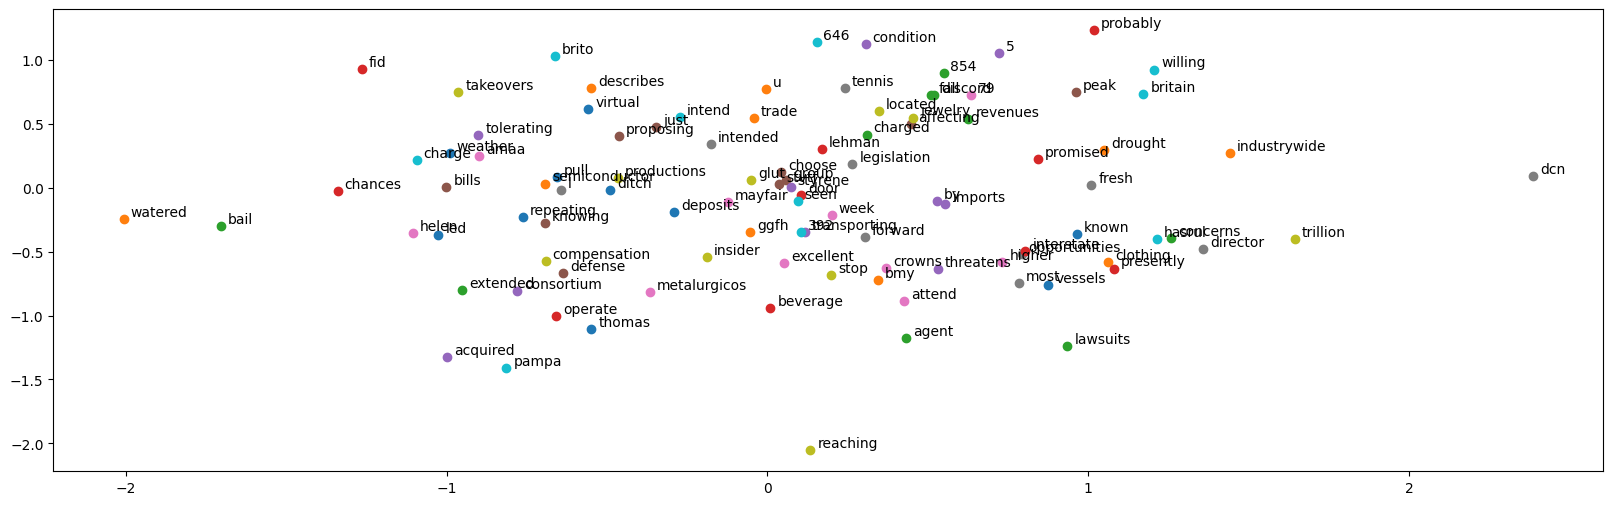

In [45]:
plt.figure(figsize=(20, 6))
for i, word in enumerate(vocabs[:100]):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 6. Cosine similarity

In [46]:
agent = get_embed('agent')
agent

(0.43196311593055725, -1.1730244159698486)

In [47]:
lawsuit = get_embed('lawsuit')
lawsuit

(0.5896140933036804, 0.3705478310585022)

In [48]:
unk = get_embed('<UNK>')
unk

(0.5896140933036804, 0.3705478310585022)

In [49]:
np.array(agent) @ np.array(unk)

-0.17997011217626557

In [50]:
np.array(agent) @ np.array(lawsuit)

-0.17997011217626557

In [51]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(agent), np.array(unk)))
print(cosine_similarity(np.array(agent), np.array(lawsuit)))

-0.20674298525843687
-0.20674298525843687


## 7. Save

The purpose of saving the word2index and index2word dictionaries to JSON files is to preserve them for future use. These dictionaries contain mappings between words and their corresponding indices, and vice versa. 

In [52]:
word2index_path = './model/word2index_skipgram_neg.json'  
index2word_path = './model/index2word_skipgram_neg.json'  

with open(word2index_path, 'w') as file:
    json.dump(word2index, file)  

with open(index2word_path, 'w') as file:
    json.dump(index2word, file)  

In [53]:
# The purpose of saving the corpus is to preserve it for future use, 
# allowing easy access to the preprocessed text data without the need to tokenize again.corpus_path = './mode/corpus.txt'
corpus_path = './model/corpus_neg.txt'

with open(corpus_path, 'w') as file:
    for sentence in corpus:
        # Join the tokens of the sentence into a single string with spaces and write it to the file
        file.write(' '.join(sentence) + '\n')


In [54]:
# Define the vocabulary size and embedding size
voc_size_w2i = len(word2index)
emb_size = emb_size  #  emb_size is previously defined in the code

# Define paths for saving model state and configuration
model_path = './model/word2vec_model_skipgram_neg.pth'
config_path = './model/word2vec_config_skipgram_neg.json'

# Save the model state to a file
torch.save(model.state_dict(), model_path)

# Save the model configuration to a JSON file
with open(config_path, 'w') as config_file:
    config = {'voc_size': voc_size_w2i , 'emb_size': emb_size}
    json.dump(config, config_file)

# Print messages indicating successful saving of model and configuration
print(f"Model saved to {model_path}")
print(f"Configuration saved to {config_path}")


Model saved to ./model/word2vec_model_skipgram_neg.pth
Configuration saved to ./model/word2vec_config_skipgram_neg.json


Model File (word2vec_model_skipgram_neg.pth):

This file saves the state of the word2vec model. It includes the trained parameters of the model, such as weights and biases, which define the learned embeddings. Saving the model state allows you to load the trained model later for inference or further training without needing to retrain it from scratch.

Config File (word2vec_config_skipgram_neg.json):

This file saves the configuration of the word2vec model. It typically includes important parameters or settings used during training, such as the vocabulary size (voc_size) and the embedding size (emb_size). Saving the model configuration allows you to reproduce the training setup and settings when loading the model for future use.

## 8. Inference 


In [55]:
import json

word2index_path = './model/word2index_skipgram_neg.json'  # Path to the JSON file containing word-to-index mappings
index2word_path = './model/index2word_skipgram_neg.json'  # Path to the JSON file containing index-to-word mappings

# Load word-to-index dictionary from JSON file
with open(word2index_path, 'r') as file:
    word2index = json.load(file)  # Load the word2index dictionary from the JSON file

# Load index-to-word dictionary from JSON file
with open(index2word_path, 'r') as file:
    index2word = json.load(file)  # Load the index2word dictionary from the JSON file

# Print loaded dictionaries
print("Word to Index Dictionary:")
print(word2index)
print("\nIndex to Word Dictionary:")
print(index2word)


Word to Index Dictionary:
{'deposits': 0, 'ggfh': 1, '854': 2, 'door': 3, 'consortium': 4, 'knowing': 5, 'higher': 6, 'opportunities': 7, 'insider': 8, 'willing': 9, 'repeating': 10, 'trade': 11, 'discord': 12, 'beverage': 13, '5': 14, 'bills': 15, 'week': 16, 'most': 17, 'productions': 18, 'seen': 19, 'led': 20, 'semiconductor': 21, 'bail': 22, 'probably': 23, 'tolerating': 24, 'choose': 25, 'attend': 26, 'fresh': 27, 'reaching': 28, 'pampa': 29, 'thomas': 30, 'clothing': 31, 'charged': 32, 'promised': 33, 'threatens': 34, 'just': 35, 'mayfair': 36, 'dcn': 37, 'compensation': 38, 'hasrul': 39, 'known': 40, 'bmy': 41, 'concerns': 42, 'operate': 43, 'condition': 44, 'stvtf': 45, '79': 46, 'tennis': 47, 'located': 48, 'charge': 49, 'pull': 50, 'industrywide': 51, 'revenues': 52, 'interstate': 53, 'imports': 54, 'affecting': 55, 'metalurgicos': 56, 'forward': 57, 'takeovers': 58, 'intend': 59, 'weather': 60, 'watered': 61, 'agent': 62, 'presently': 63, 'transporting': 64, 'proposing': 65,

In [56]:
path = './model/corpus_neg.txt' 
def corpus_infer(path):
    corpus = []
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line:  
                corpus.append(line)
    return corpus

corpus = corpus_infer(path)


In [58]:
# Load the word2vec model and its configuration
def load_word2vec_model(model_path, config_path):
    """
    Load the pre-trained word2vec model and its configuration.

    Args:
    - model_path (str): Path to the file containing the model state.
    - config_path (str): Path to the file containing the model configuration.

    Returns:
    - loaded_model: The loaded word2vec model.
    - voc_size (int): The vocabulary size.
    - emb_size (int): The embedding size.
    """
    # Load configuration
    with open(config_path, 'r') as config_file:
        config = json.load(config_file)
    voc_size = config['voc_size']
    emb_size = config['emb_size']

    # Initialize model
    loaded_model = SkipgramNeg(voc_size, emb_size)
    
    # Load model state
    loaded_model.load_state_dict(torch.load(model_path))
    
    # Set model to evaluation mode
    loaded_model.eval()

    print("Model loaded")
    
    return loaded_model, voc_size, emb_size

# Preprocess the text
def tokenize_text(text):
    """
    Tokenize the input text into words.

    Args:
    - text (str): Input text to be tokenized.

    Returns:
    - tokens (list): List of tokens obtained from the input text.
    """
    tokens = nltk.word_tokenize(text.lower())
    return tokens

# Get the embedding for a given text
def get_text_embedding(text, model, word2index):
    """
    Get the embedding for a given text using the word2vec model.

    Args:
    - text (str): Input text.
    - model: Pre-trained word2vec model.
    - word2index (dict): Word-to-index mapping.

    Returns:
    - text_embedding (np.array): Embedding vector for the input text.
    """
    tokens = tokenize_text(text)
    embeddings = []

    for token in tokens:
        index = word2index.get(token, word2index.get('<UNK>'))
        word_tensor = torch.LongTensor([index])

        embed_center = model.embedding_center(word_tensor)
        embed_outside = model.embedding_outside(word_tensor)
        embed = (embed_center + embed_outside) / 2
        embeddings.append(embed.detach().numpy())
    
    if embeddings:
        embeddings = np.array(embeddings)
        text_embedding = np.mean(embeddings, axis=0)

    text_embedding = text_embedding.flatten()  # Flatten the array to ensure it's 1-D
    
    return text_embedding

# Retrieve top passages similar to the query
def find_similar_passages(query, corpus, model, word2index, top_n=20):
    """
    Find top passages similar to the input query from the corpus.

    Args:
    - query (str): Input query.
    - corpus (list): List of passages in the corpus.
    - model: Pre-trained word2vec model.
    - word2index (dict): Word-to-index mapping.
    - top_n (int): Number of top passages to retrieve.

    Returns:
    - top_passages (list): List of top passages along with their similarity scores.
    """
    # Convert query to embedding
    query_embedding = get_text_embedding(query, model, word2index)
    similarities = []

    # Compute similarity between query and each passage in corpus
    for passage in corpus:
        passage_embedding = get_text_embedding(passage, model, word2index)
        similarity = np.dot(query_embedding, passage_embedding)
        similarities.append(similarity)

    # Sort passages based on similarity scores
    sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)
    top_indices = sorted_indices[:top_n]

    # Retrieve top passages along with similarity scores
    top_passages = [(corpus[idx], (similarities[idx]) * 100) for idx in top_indices]
    
    return top_passages


# Load the word2vec model and its configuration
loaded_model, voc_size, emb_size = load_word2vec_model(model_path, config_path)

# Example usage with a different query
new_query = "the analysts agreed the bank was aggressive"
print('Search query: ', new_query)
top_passages = find_similar_passages(new_query, corpus, loaded_model, word2index, top_n=20)
i = 1
print("Top Similar Passages with similarity score")
for passage, score in top_passages:
    print(i, passage,'\t\t\t\t\t\t', score)
    i += 1

Model loaded
Search query:  the analysts agreed the bank was aggressive
Top Similar Passages with similarity score
1 payable may 11 record april 24 						 17.347359657287598
2 the payout of existing preferred shareholders will be completed just before next month ' s initial distribution to common shareholders , continental added . 						 15.829388797283173
3 finally , there is a shortage of lorries to transport the crops . 						 15.648728609085083
4 the analysts agreed the bank was aggressive . 						 15.28579443693161
5 the annual shareholder meeting will be held in london on april 29 . 						 15.064595639705658
6 some analysts today recommended clients not buy burlington at its current levels . 						 14.482024312019348
7 the pay dispute went before a hearing of the arbitration commission today . 						 14.349552989006042
8 the pay dispute went before a hearing of the arbitration commission today . 						 14.349552989006042
9 rubbermaid inc 1st qtr shr 28 cts vs 22 cts rubbermaid in